# スタッキング

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
from subprocess import call

In [2]:
# 表示する文字サイズを調整
plt.rc("font", size=20)
plt.rc("legend", fontsize=16)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)

import IPython.display
from IPython.display import Image

# 乱数
import numpy as np
np.random.seed(777)

# 実験用のデータを作成

In [3]:
# 特徴が20あるデータを作成
n_features = 20
X, y = make_classification(
    n_samples=2500,
    n_features=n_features,
    n_informative=10,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=777,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=777
)

## データを複数の特徴に関してプロットしてみる
単純なルールでは分類できなさそうであることを確認する。

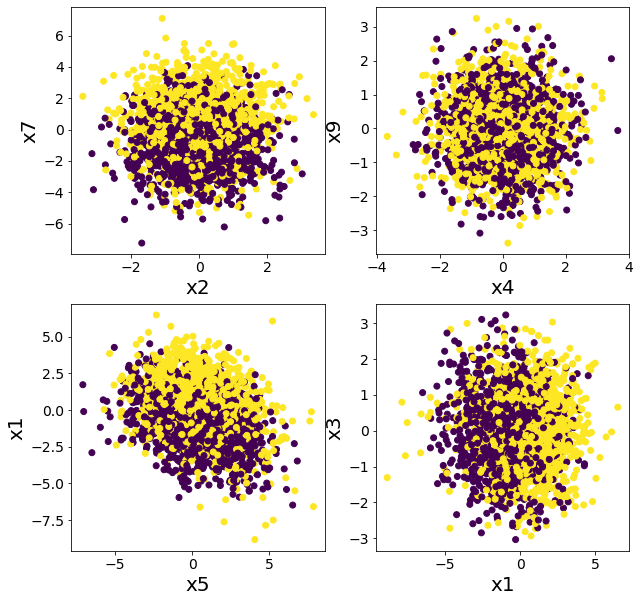

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(X[:, 2], X[:, 7], c=y)
plt.xlabel("x2")
plt.ylabel("x7")
plt.subplot(2, 2, 2)
plt.scatter(X[:, 4], X[:, 9], c=y)
plt.xlabel("x4")
plt.ylabel("x9")
plt.subplot(2, 2, 3)
plt.scatter(X[:, 5], X[:, 1], c=y)
plt.xlabel("x5")
plt.ylabel("x1")
plt.subplot(2, 2, 4)
plt.scatter(X[:, 1], X[:, 3], c=y)
plt.xlabel("x1")
plt.ylabel("x3")
plt.show()

# スタッキングとランダムフォレストの比較

## ランダムフォレストで分類してみた場合

In [5]:
model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rf_score = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC = {rf_score}")

ROC-AUC = 0.855797033310609


## 複数の木でスタッキングした場合
`DecisionTreeClassifier`のみでスタッキングしても精度があまり向上しないことが確認できる。

[sklearn.ensemble.StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [6]:
# スタッキング前段に使用するモデル
estimators = [
    ("dt1", DecisionTreeClassifier(max_depth=3, random_state=777)),
    ("dt2", DecisionTreeClassifier(max_depth=4, random_state=777)),
    ("dt3", DecisionTreeClassifier(max_depth=5, random_state=777)),
    ("dt4", DecisionTreeClassifier(max_depth=6, random_state=777)),
]
# スタッキングに含まれるモデル数
n_estimators = len(estimators)
# スタッキング後段に使用するモデル
final_estimator = DecisionTreeClassifier(max_depth=3, random_state=777)
# スタッキングモデルを作成し訓練する
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(X_train, y_train)
# テストデータで評価する
y_pred = clf.predict(X_test)
clf_score = roc_auc_score(y_test, y_pred)

print("ROC-AUC")
print(f"決定木のスタッキング＝{clf_score}, ランダムフォレスト＝{rf_score}")

ROC-AUC
決定木のスタッキング＝0.7359716965608031, ランダムフォレスト＝0.855797033310609


## スタッキングに使用した木を可視化してみる

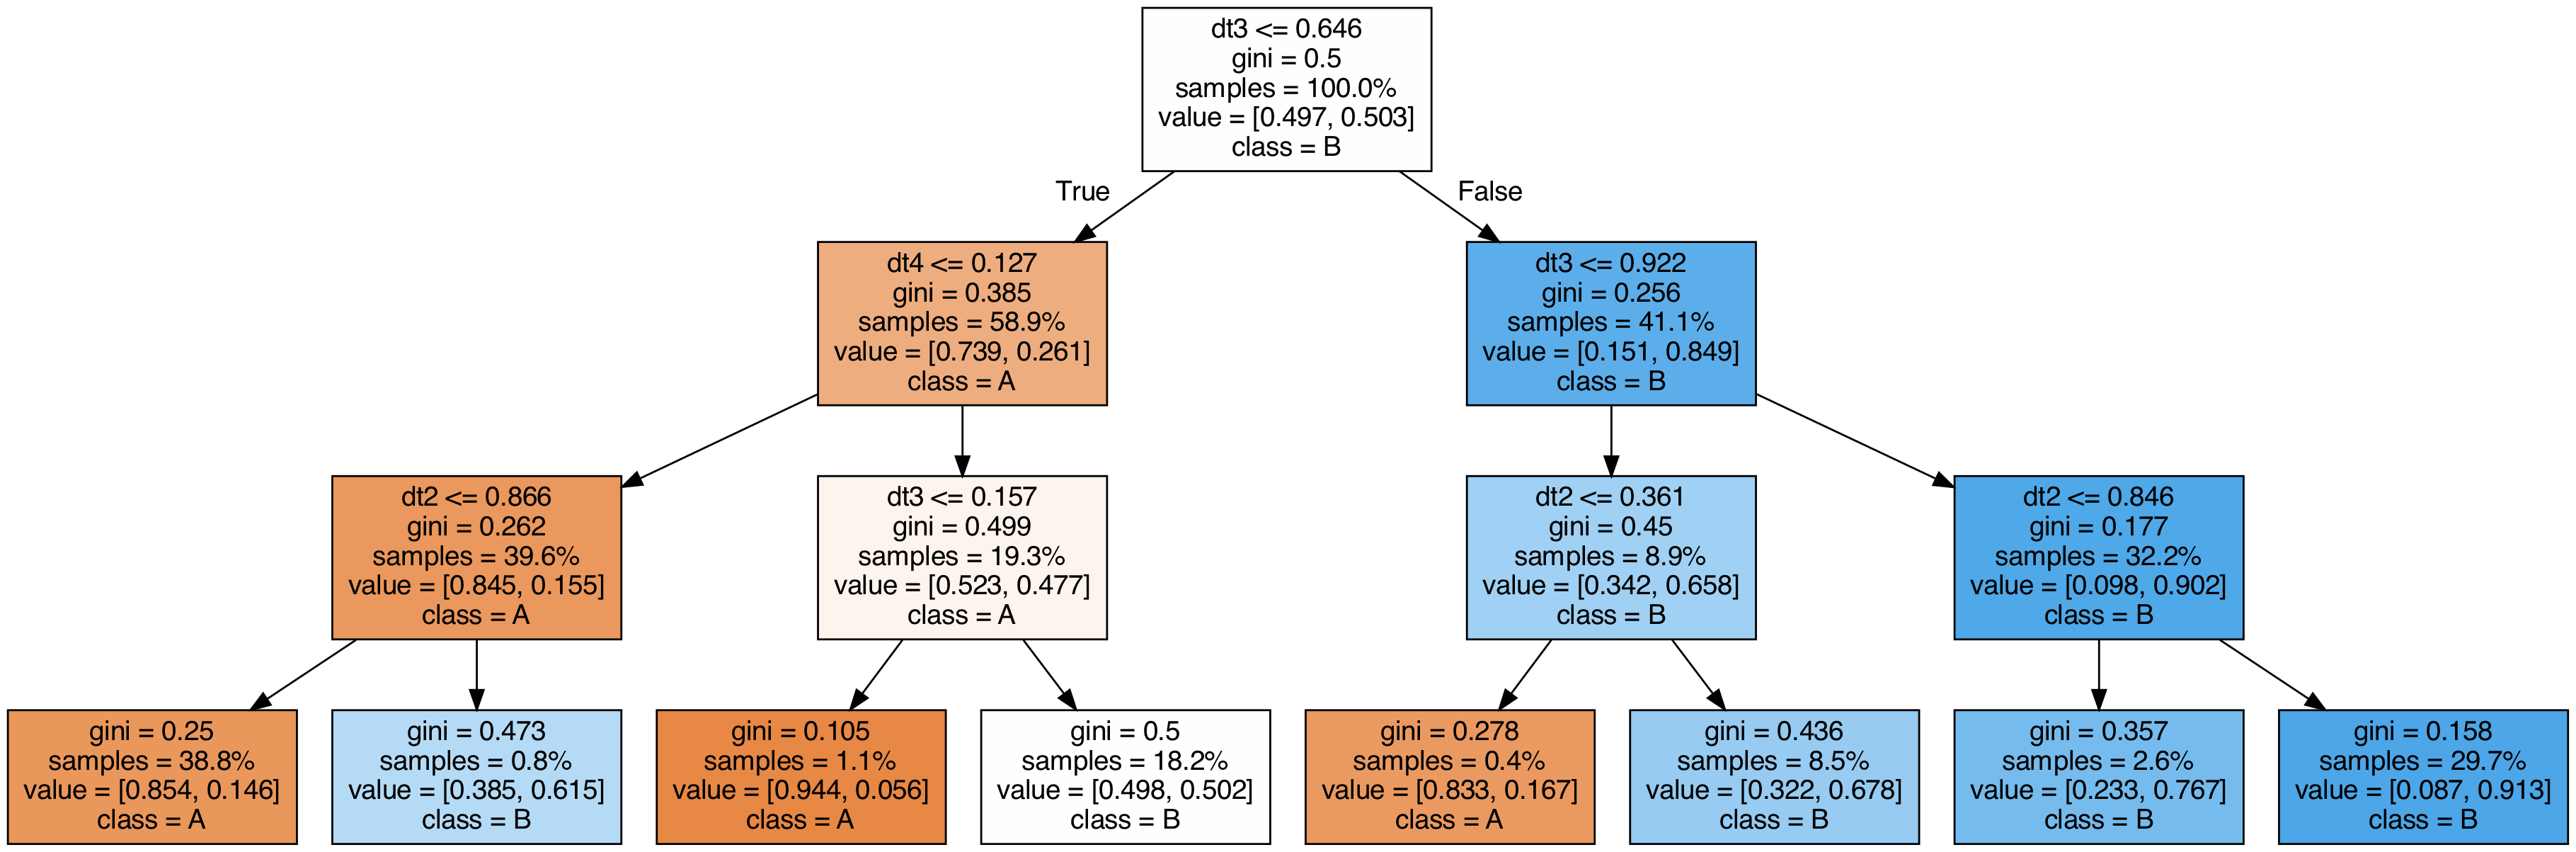

In [7]:
export_graphviz(
    clf.final_estimator_,
    out_file="tree_final_estimator.dot",
    class_names=["A", "B"],
    feature_names=[e[0] for e in estimators],
    proportion=True,
    filled=True,
)

call(
    [
        "dot",
        "-Tpng",
        "tree_final_estimator.dot",
        "-o",
        f"tree_final_estimator.png",
        "-Gdpi=200",
    ]
)
display(Image(filename="tree_final_estimator.png"))

## スタッキングで使用した木の特徴重要度を見る
スタッキングしたものの、結局4番目の木しかほとんど予測に利用されていないことが分かる。

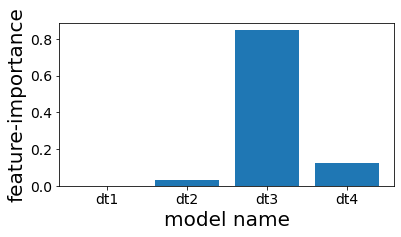

In [8]:
plt.figure(figsize=(6, 3))
plot_index = [i for i in range(n_estimators)]
plt.bar(plot_index, clf.final_estimator_.feature_importances_)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("feature-importance")
plt.show()

## スタッキング前段の各木の性能を確認する

====
DecisionTreeClassifier(max_depth=3, random_state=777)
0.7660117774277722
====
DecisionTreeClassifier(max_depth=4, random_state=777)
0.7744128916993818
====
DecisionTreeClassifier(max_depth=5, random_state=777)
0.8000158677919086
====
DecisionTreeClassifier(max_depth=6, random_state=777)
0.8084639977432473


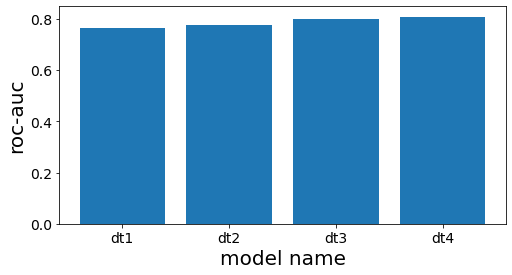

In [9]:
# スタッキング前段の木の精度を計測する
scores = []
for clf_estim in clf.estimators_:
    print("====")
    y_pred = clf_estim.predict(X_test)
    scr = roc_auc_score(y_test, y_pred)
    scores.append(scr)
    print(clf_estim)
    print(scr)

n_estimators = len(estimators)
plot_index = [i for i in range(n_estimators)]

# グラフ作成
plt.figure(figsize=(8, 4))
plt.bar(plot_index, scores)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("roc-auc")
plt.show()

### スタッキングに関する発展的な資料
- [Stacked Generalization (Stacking)](http://machine-learning.martinsewell.com/ensembles/stacking/)
- [MLWave/Kaggle-Ensemble-Guide](https://github.com/MLWave/Kaggle-Ensemble-Guide)